In [1]:
import numpy as np
from model_vanilla_shiftx import DCGAN
from utils import pp, visualize, to_json, show_all_variables, expand_path, timestamp

import tensorflow as tf
import cv2
import time
import io
import IPython.display
import PIL.Image
import matplotlib.pyplot as plt

In [2]:
def imshow(a, im_size=256, format='png', jpeg_fallback=True, filename=None):
  if a.dtype != np.uint8:
      a = a*255
  a = np.asarray(a, dtype=np.uint8)
  a = cv2.resize(a, (a.shape[1], a.shape[0]))

  str_file = io.BytesIO()
  PIL.Image.fromarray(a).save(str_file, format)
  im_data = str_file.getvalue()
  try:
    disp = IPython.display.display(IPython.display.Image(im_data))
    if filename:
        size = (a.shape[1]//2, a.shape[0]//2)
        im = PIL.Image.fromarray(a)
        im.thumbnail(size,PIL.Image.ANTIALIAS)
        im.save('{}.{}'.format(filename, format))
        
  except IOError:
    if jpeg_fallback and format != 'jpeg':
      print ('Warning: image was too large to display in format "{}"; '
             'trying jpeg instead.').format(format)
      return imshow(a, format='jpeg')
    else:
      raise
  return disp

In [3]:
def imgrid(imarray, cols=5, pad=1):
  if imarray.dtype != np.uint8:
    raise ValueError('imgrid input imarray must be uint8')
  pad = int(pad)
  assert pad >= 0
  cols = int(cols)
  assert cols >= 1
  N, H, W, C = imarray.shape
  rows = int(np.ceil(N / float(cols)))
  batch_pad = rows * cols - N
  assert batch_pad >= 0
  post_pad = [batch_pad, pad, pad, 0]
  pad_arg = [[0, p] for p in post_pad]
  imarray = np.pad(imarray, pad_arg, 'constant', constant_values=255)
  H += pad
  W += pad
  grid = (imarray
          .reshape(rows, cols, H, W, C)
          .transpose(0, 2, 1, 3, 4)
          .reshape(rows*H, cols*H, C))
  if pad:
    grid = grid[:-pad, :-pad]
  return grid

In [4]:
initializer = tf.global_variables_initializer()
config = tf.ConfigProto(log_device_placement=False)
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
#sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
sess.run(initializer)

In [5]:
def initialize_uninitialized(sess):
    global_vars          = tf.global_variables()
    is_not_initialized   = sess.run([tf.is_variable_initialized(var) for var in global_vars])
    not_initialized_vars = [v for (v, f) in zip(global_vars, is_not_initialized) if not f]

    print([str(i.name) for i in not_initialized_vars]) # only for testing
    if len(not_initialized_vars):
        sess.run(tf.variables_initializer(not_initialized_vars))
        return not_initialized_vars

In [6]:
checkpoint_dir = "./out/shiftx_aug_argminW_lr0.0005/checkpoint"
sample_dir = "./out/shiftx_aug_argminW_lr0.0005/sample"
num_samples = 10 # 1 sample per digit

flags = tf.app.flags
flags.DEFINE_integer("epoch", 25, "Epoch to train [25]")
flags.DEFINE_float("learning_rate", 0.0002, "Learning rate of for adam [0.0002]")
flags.DEFINE_float("beta1", 0.5, "Momentum term of adam [0.5]")
flags.DEFINE_float("train_size", np.inf, "The size of train images [np.inf]")
flags.DEFINE_integer("batch_size", num_samples, "The size of batch images [64]")
flags.DEFINE_integer("input_height", 28, "The size of image to use (will be center cropped). [108]")
flags.DEFINE_integer("input_width", 28, "The size of image to use (will be center cropped). If None, same value as input_height [None]")
flags.DEFINE_integer("output_height", 28, "The size of the output images to produce [64]")
flags.DEFINE_integer("output_width", 28, "The size of the output images to produce. If None, same value as output_height [None]")
flags.DEFINE_string("dataset", "mnist", "The name of dataset [celebA, mnist, lsun]")
flags.DEFINE_string("input_fname_pattern", "*.jpg", "Glob pattern of filename of input images [*]")
flags.DEFINE_string("data_dir", "./data", "path to datasets [e.g. $HOME/data]")
flags.DEFINE_string("out_dir", "./out", "Root directory for outputs [e.g. $HOME/out]")
flags.DEFINE_string("out_name", "", "Folder (under out_root_dir) for all outputs. Generated automatically if left blank []")
# flags.DEFINE_string("checkpoint_dir", "checkpoint", "Folder (under out_root_dir/out_name) to save checkpoints [checkpoint]")
flags.DEFINE_string("checkpoint_dir", checkpoint_dir, "Folder (under out_root_dir/out_name) to save checkpoints [checkpoint]")
# flags.DEFINE_string("sample_dir", "samples", "Folder (under out_root_dir/out_name) to save samples [samples]")
flags.DEFINE_string("sample_dir", sample_dir, "Folder (under out_root_dir/out_name) to save samples [samples]")
flags.DEFINE_boolean("train", False, "True for training, False for testing [False]")
flags.DEFINE_boolean("crop", False, "True for training, False for testing [False]")
flags.DEFINE_boolean("visualize", False, "True for visualizing, False for nothing [False]")
flags.DEFINE_boolean("export", False, "True for exporting with new batch size")
flags.DEFINE_boolean("freeze", False, "True for exporting with new batch size")
flags.DEFINE_integer("max_to_keep", 1, "maximum number of checkpoints to keep")
flags.DEFINE_integer("sample_freq", 200, "sample every this many iterations")
flags.DEFINE_integer("ckpt_freq", 200, "save checkpoint every this many iterations")
flags.DEFINE_integer("z_dim", 100, "dimensions of z")
flags.DEFINE_integer("y_dim", 10, "choose dimensions of y to be 10")
flags.DEFINE_string("z_dist", "uniform_signed", "'normal01' or 'uniform_unsigned' or uniform_signed")
flags.DEFINE_boolean("G_img_sum", False, "Save generator image summaries in log")
#flags.DEFINE_integer("generate_test_images", 100, "Number of images to generate during test. [100]")
# only for jupyter:
flags.DEFINE_string('f', '', 'kernel')

FLAGS = flags.FLAGS

In [7]:
num_samples = FLAGS.batch_size # this is a bug, DCGAN.y placeholder is fixed to 64 but what if we want 1 sample?
dcgan = DCGAN(
    sess,
    input_width=FLAGS.input_width,
    input_height=FLAGS.input_height,
    output_width=FLAGS.output_width,
    output_height=FLAGS.output_height,
    batch_size=FLAGS.batch_size,
    sample_num=num_samples,
    y_dim=FLAGS.y_dim,
    z_dim=FLAGS.z_dim,
    dataset_name=FLAGS.dataset,
    input_fname_pattern=FLAGS.input_fname_pattern,
    crop=FLAGS.crop,
    checkpoint_dir=FLAGS.checkpoint_dir,
    sample_dir=FLAGS.sample_dir,
    data_dir=FLAGS.data_dir,
    out_dir=FLAGS.out_dir,
    max_to_keep=FLAGS.max_to_keep)

load_success, load_counter = dcgan.load(FLAGS.checkpoint_dir)
if not load_success:
    raise Exception("Checkpoint not found in " + FLAGS.checkpoint_dir)

shiftx aug is disabled
loading mnist without augmenting ...
Building model_vanilla_shiftx ...
 [*] Reading checkpoints... ./out/shiftx_aug_argminW_lr0.0005/checkpoint
INFO:tensorflow:Restoring parameters from ./out/shiftx_aug_argminW_lr0.0005/checkpoint/model.b64-109200
 [*] Success to read model.b64-109200


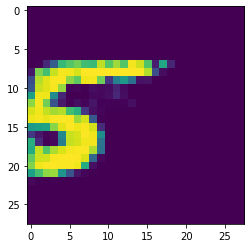

In [8]:
## Testing previously trained G
# visualize(sess, dcgan, FLAGS, 1, FLAGS.sample_dir)
z_sample = np.random.uniform(-1, 1, size=(num_samples, FLAGS.z_dim))

y = np.random.choice(FLAGS.y_dim, num_samples)
y_one_hot = np.zeros((num_samples, FLAGS.y_dim))
y_one_hot[np.arange(num_samples), y] = 1

samples = sess.run(dcgan.sampler, feed_dict={dcgan.z: z_sample, dcgan.y: y_one_hot})
plt.imshow(samples[0,:,:,0])

In [9]:
## steerability walk
## define the graph
z_placeholder = tf.placeholder(tf.float32, [None, FLAGS.z_dim], name='z_sample')
y_placeholder = tf.placeholder(tf.float32, [None, FLAGS.y_dim], name='y_sample')

## this will go to get_target and then to the loss
outputs_orig = dcgan.my_sampler(z_placeholder, y_placeholder)

img_size = 28
Nsliders = 1
target = tf.placeholder(tf.float32, shape=(None, img_size, img_size, Nsliders))
mask = tf.placeholder(tf.float32, shape=(None, img_size, img_size, Nsliders))
alpha = tf.placeholder(tf.float32, shape=None)
w = tf.Variable(np.random.uniform(-1, 1, [1, FLAGS.z_dim]), name='walk', dtype=np.float32)

z_new = z_placeholder+alpha*w
y_new = y_placeholder

## this is our transformed
transformed_output = dcgan.my_sampler(z_new, y_new)

loss = tf.losses.compute_weighted_loss(tf.square(transformed_output-target), weights=mask)
lr = 0.005
train_step = tf.train.AdamOptimizer(lr).minimize(loss, var_list=tf.trainable_variables(scope='walk'), 
                                                 name='AdamOpter')

## the graph already contains DCGAN and now we want to init the steerability part in it:
not_initialized_vars = initialize_uninitialized(sess)

['walk:0', 'beta1_power:0', 'beta2_power:0', 'walk/Adam:0', 'walk/Adam_1:0']


In [10]:
def get_target_np(outputs_zs, alpha, show_img=False, show_mask=False):
    
    mask_fn = np.ones(outputs_zs.shape)
    if alpha == 0:
        return outputs_zs, mask_fn
    
    M = np.float32([[1,0,alpha],[0,1,0]])
    target_fn = np.zeros(outputs_zs.shape)
    mask_out = np.zeros(outputs_zs.shape)
    for i in range(outputs_zs.shape[0]):
        target_fn[i,:,:,:] = np.expand_dims(cv2.warpAffine(outputs_zs[i,:,:,:], M, (img_size, img_size)), axis=2)
        mask_out[i,:,:,:] = np.expand_dims(cv2.warpAffine(mask_fn[i,:,:,:], M, (img_size, img_size)), axis=2)

    mask_out[np.nonzero(mask_out)] = 1.
    assert(np.setdiff1d(mask_out, [0., 1.]).size == 0)
        
    if show_img:
        print('Target image:')
#         imshow_unscaled(target_fn)
        imshow(target_fn[0,:,:,0], im_size=128)
    if show_mask:
        print('Target mask:')
#         imshow_unscaled(mask_out)
        imshow(mask_out[0,:,:,0], im_size=128)

    return target_fn, mask_out

In [11]:
# ! mkdir -p shift_l2_git/images
# ! mkdir -p shift_l2_git/output
import os
output_dir = './out/walk_train_aug/shiftx_l2_git{}'.format(lr)
os.makedirs(os.path.join(output_dir, 'images'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'output'), exist_ok=True)
saver = tf.train.Saver(tf.trainable_variables(scope=None))

In [12]:
# This can be train.py

import logging
import sys
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(threadName)-12.12s] [%(levelname)-5.5s]  %(message)s",
    handlers=[
        logging.FileHandler("{0}/{1}.log".format(output_dir, 'train')),
        logging.StreamHandler(sys.stdout)
    ])
logger = logging.getLogger()

alpha_list = []
loss_vals = []

# train
train_sample_size = 40000
def train(saver):
    # init zs
    # we want couple of thousands per category, also compatible with batch_size
    num_samples = train_sample_size
    # sample inputs to feed to placeholders
    zs = np.random.uniform(-1, 1, size=(num_samples, FLAGS.z_dim))

    # all categories
    y = np.random.choice(FLAGS.y_dim, num_samples)
    ys = np.zeros((num_samples, FLAGS.y_dim))
    ys[np.arange(num_samples), y] = 1

    Loss_sum = 0;
    n_epoch = 1
    optim_iter = 0
    batch_size = FLAGS.batch_size
    loss_values = []
    Loss_sum_iter = 0  
    alpha_val_max = 5
    
    for epoch in range(n_epoch):
        for batch_start in range(0, num_samples, batch_size):
            start_time = time.time()
            
            alpha_val = np.random.randint(1, alpha_val_max + 1)  
            coin = np.random.uniform(0, 1)
            if coin <= 0.5:
                alpha_val = -alpha_val

            s = slice(batch_start, min(num_samples, batch_start + batch_size))

            feed_dict_out = {z_placeholder: zs[s], y_placeholder: ys[s]}
            out_zs = sess.run(outputs_orig, feed_dict_out)
            
            target_fn, mask_out = get_target_np(out_zs, alpha_val)#, show_img=True, show_mask=True)

            feed_dict = {z_placeholder: zs[s], y_placeholder: ys[s], alpha: alpha_val/alpha_val_max, target: target_fn, mask: mask_out}
            curr_loss, _ = sess.run([loss, train_step], feed_dict=feed_dict)
            Loss_sum = Loss_sum + curr_loss
            Loss_sum_iter = Loss_sum_iter + curr_loss
            
            elapsed_time = time.time() - start_time

            logger.info('T, epc, bst, lss, a: {}, {}, {}, {}, {}'.format(elapsed_time, epoch, batch_start, curr_loss, alpha_val))

            alpha_list.append(alpha_val)

            if (optim_iter % 2500 == 0) and (optim_iter > 0):
                saver.save(sess, '{}/{}/model_{}.ckpt'.format(output_dir, 'output', optim_iter*batch_size), write_meta_graph=False, write_state=False)
            
            if (optim_iter % 100 == 0) and (optim_iter > 0):
                loss_vals.append(Loss_sum_iter/(100*batch_size))
                Loss_sum_iter = 0
                print('Loss:', loss_vals)

            optim_iter = optim_iter+1
            
    if optim_iter > 0:
        print('average loss with this metric: ', Loss_sum/(optim_iter*batch_size))
    saver.save(sess, '{}/{}/model_{}.ckpt'.format(output_dir, 'output', optim_iter*batch_size), write_meta_graph=False, write_state=False)

In [13]:
train(dcgan.saver)

2019-09-21 15:49:22,405 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.28489017486572266, 0, 0, 0.08272280544042587, 2
2019-09-21 15:49:22,424 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.017777442932128906, 0, 10, 0.10657622665166855, -2
2019-09-21 15:49:22,444 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018440723419189453, 0, 20, 0.04226427152752876, -1
2019-09-21 15:49:22,464 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01844501495361328, 0, 30, 0.04443885013461113, 1
2019-09-21 15:49:22,483 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01850271224975586, 0, 40, 0.12500204145908356, 5
2019-09-21 15:49:22,503 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01855301856994629, 0, 50, 0.12542271614074707, -5
2019-09-21 15:49:22,523 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01856517791748047, 0, 60, 0.12319350242614746, -3
2019-09-21 15:49:22,542 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018424034118652344, 0, 70, 0.13671517372131348, -5
2019-09-21 15:49:22,562 [MainThre

2019-09-21 15:49:23,603 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01840949058532715, 0, 680, 0.05820850655436516, 2
2019-09-21 15:49:23,627 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.02286553382873535, 0, 690, 0.02435210533440113, 1
2019-09-21 15:49:23,646 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01760554313659668, 0, 700, 0.06897890567779541, 2
2019-09-21 15:49:23,666 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018538951873779297, 0, 710, 0.06710877269506454, -2
2019-09-21 15:49:23,686 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018524885177612305, 0, 720, 0.09767915308475494, -3
2019-09-21 15:49:23,709 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.022163867950439453, 0, 730, 0.058342959731817245, -2
2019-09-21 15:49:23,734 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.02436995506286621, 0, 740, 0.09821751713752747, 4
2019-09-21 15:49:23,756 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.020757436752319336, 0, 750, 0.12358863651752472, 4
2019-09-21 15:49:23,776 

2019-09-21 15:49:24,959 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.022623777389526367, 0, 1350, 0.026340404525399208, -1
2019-09-21 15:49:24,978 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01854419708251953, 0, 1360, 0.12580841779708862, -5
2019-09-21 15:49:24,998 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018510818481445312, 0, 1370, 0.030345292761921883, -1
2019-09-21 15:49:25,017 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018072843551635742, 0, 1380, 0.11252101510763168, -3
2019-09-21 15:49:25,037 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018462657928466797, 0, 1390, 0.05714433267712593, 2
2019-09-21 15:49:25,057 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01858973503112793, 0, 1400, 0.03176596015691757, -1
2019-09-21 15:49:25,073 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.014969825744628906, 0, 1410, 0.08172877877950668, -3
2019-09-21 15:49:25,083 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00870823860168457, 0, 1420, 0.0698186606168747, 3
2019-09-21 1

2019-09-21 15:49:26,158 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018213272094726562, 0, 2020, 0.0728711485862732, 2
2019-09-21 15:49:26,178 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0184781551361084, 0, 2030, 0.024082781746983528, 1
2019-09-21 15:49:26,197 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018334627151489258, 0, 2040, 0.124962717294693, 5
2019-09-21 15:49:26,219 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0207674503326416, 0, 2050, 0.1284988522529602, -5
2019-09-21 15:49:26,241 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018477916717529297, 0, 2060, 0.11076278239488602, -3
2019-09-21 15:49:26,260 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018363475799560547, 0, 2070, 0.12266682833433151, 5
2019-09-21 15:49:26,280 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018397092819213867, 0, 2080, 0.05382664129137993, 2
2019-09-21 15:49:26,300 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0185239315032959, 0, 2090, 0.10530517995357513, -5
2019-09-21 15:49:26,31

2019-09-21 15:49:27,330 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018662452697753906, 0, 2690, 0.09285038709640503, 4
2019-09-21 15:49:27,349 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01862311363220215, 0, 2700, 0.14286857843399048, -5
2019-09-21 15:49:27,369 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018527984619140625, 0, 2710, 0.08442326635122299, -4
2019-09-21 15:49:27,389 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018633365631103516, 0, 2720, 0.02803320251405239, 1
2019-09-21 15:49:27,408 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018553733825683594, 0, 2730, 0.026617763563990593, -1
2019-09-21 15:49:27,428 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018494606018066406, 0, 2740, 0.08212744444608688, 3
2019-09-21 15:49:27,447 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018480777740478516, 0, 2750, 0.13579422235488892, -5
2019-09-21 15:49:27,467 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018549442291259766, 0, 2760, 0.03421364724636078, -1
2019-09-21 

2019-09-21 15:49:28,632 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018290042877197266, 0, 3350, 0.028162827715277672, -1
2019-09-21 15:49:28,652 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018693208694458008, 0, 3360, 0.05888567492365837, 2
2019-09-21 15:49:28,671 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01848745346069336, 0, 3370, 0.08493660390377045, -3
2019-09-21 15:49:28,691 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018649578094482422, 0, 3380, 0.023982025682926178, -1
2019-09-21 15:49:28,711 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01875448226928711, 0, 3390, 0.10663723945617676, -5
2019-09-21 15:49:28,730 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018683195114135742, 0, 3400, 0.11801458150148392, -5
2019-09-21 15:49:28,750 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01860356330871582, 0, 3410, 0.04333444684743881, -1
2019-09-21 15:49:28,770 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018677473068237305, 0, 3420, 0.02311680279672146, 1
2019-09-21 

2019-09-21 15:49:29,831 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.017545223236083984, 0, 4020, 0.08655361831188202, -3
2019-09-21 15:49:29,851 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018435955047607422, 0, 4030, 0.12281889468431473, 5
2019-09-21 15:49:29,871 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01854419708251953, 0, 4040, 0.057736676186323166, 2
2019-09-21 15:49:29,890 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018467187881469727, 0, 4050, 0.050638262182474136, -2
2019-09-21 15:49:29,912 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.02043771743774414, 0, 4060, 0.11438442021608353, -5
2019-09-21 15:49:29,930 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.016352176666259766, 0, 4070, 0.031028034165501595, 1
2019-09-21 15:49:29,947 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.016426563262939453, 0, 4080, 0.026686621829867363, 1
2019-09-21 15:49:29,965 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.016787052154541016, 0, 4090, 0.028462572023272514, -1
2019-09-2

2019-09-21 15:49:31,015 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018625736236572266, 0, 4690, 0.05285344272851944, 2
2019-09-21 15:49:31,036 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.020907878875732422, 0, 4700, 0.08227954059839249, 2
2019-09-21 15:49:31,056 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01814866065979004, 0, 4710, 0.11119046807289124, -4
2019-09-21 15:49:31,076 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018476486206054688, 0, 4720, 0.0892469510436058, -4
2019-09-21 15:49:31,095 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01862502098083496, 0, 4730, 0.0818784162402153, -3
2019-09-21 15:49:31,115 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01864004135131836, 0, 4740, 0.05072876065969467, 2
2019-09-21 15:49:31,135 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01874852180480957, 0, 4750, 0.10824376344680786, -5
2019-09-21 15:49:31,155 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01877427101135254, 0, 4760, 0.09629273414611816, -2
2019-09-21 15:49:3

2019-09-21 15:49:32,339 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018610000610351562, 0, 5350, 0.06919380277395248, 2
2019-09-21 15:49:32,352 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.012458562850952148, 0, 5360, 0.13373765349388123, -5
2019-09-21 15:49:32,364 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010510683059692383, 0, 5370, 0.07214247435331345, -3
2019-09-21 15:49:32,373 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008212804794311523, 0, 5380, 0.0315970741212368, -1
2019-09-21 15:49:32,383 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00849771499633789, 0, 5390, 0.03463025763630867, 1
2019-09-21 15:49:32,393 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008582830429077148, 0, 5400, 0.03716680034995079, -1
2019-09-21 15:49:32,403 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00893855094909668, 0, 5410, 0.048749543726444244, -2
2019-09-21 15:49:32,413 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008577346801757812, 0, 5420, 0.10775438696146011, -5
2019-09-21 1

2019-09-21 15:49:33,521 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018572330474853516, 0, 6020, 0.0684724748134613, -2
2019-09-21 15:49:33,541 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018640995025634766, 0, 6030, 0.1050441712141037, -3
2019-09-21 15:49:33,560 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018419504165649414, 0, 6040, 0.09118865430355072, -3
2019-09-21 15:49:33,580 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018492460250854492, 0, 6050, 0.09004558622837067, 3
2019-09-21 15:49:33,600 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018572568893432617, 0, 6060, 0.02562139555811882, 1
2019-09-21 15:49:33,619 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01845836639404297, 0, 6070, 0.057157739996910095, 2
2019-09-21 15:49:33,639 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018491744995117188, 0, 6080, 0.08800426870584488, 4
2019-09-21 15:49:33,659 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01849365234375, 0, 6090, 0.06698890775442123, -2
2019-09-21 15:49:3

2019-09-21 15:49:34,721 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018548011779785156, 0, 6690, 0.08445391058921814, -4
2019-09-21 15:49:34,741 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01847982406616211, 0, 6700, 0.11925499141216278, 5
2019-09-21 15:49:34,760 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018564462661743164, 0, 6710, 0.12410063296556473, -5
2019-09-21 15:49:34,780 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018596649169921875, 0, 6720, 0.042726654559373856, 1
2019-09-21 15:49:34,800 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01856851577758789, 0, 6730, 0.12224791944026947, 5
2019-09-21 15:49:34,820 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018597841262817383, 0, 6740, 0.09543892741203308, 4
2019-09-21 15:49:34,839 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018486738204956055, 0, 6750, 0.06788156926631927, 3
2019-09-21 15:49:34,859 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018707990646362305, 0, 6760, 0.0581107996404171, 2
2019-09-21 15:49

2019-09-21 15:49:36,035 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01849675178527832, 0, 7350, 0.07367482036352158, -3
2019-09-21 15:49:36,055 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01844620704650879, 0, 7360, 0.04220591112971306, -2
2019-09-21 15:49:36,075 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018631458282470703, 0, 7370, 0.021990349516272545, -1
2019-09-21 15:49:36,094 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018451929092407227, 0, 7380, 0.024738028645515442, -1
2019-09-21 15:49:36,114 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018720149993896484, 0, 7390, 0.13522103428840637, 5
2019-09-21 15:49:36,134 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018659353256225586, 0, 7400, 0.09091012924909592, 4
2019-09-21 15:49:36,153 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018547773361206055, 0, 7410, 0.06295064091682434, 2
2019-09-21 15:49:36,173 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018640518188476562, 0, 7420, 0.04498116672039032, -2
2019-09-21 

2019-09-21 15:49:37,161 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.019049882888793945, 0, 8010, 0.029401617124676704, 1
2019-09-21 15:49:37,181 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018522262573242188, 0, 8020, 0.09600962698459625, 5
2019-09-21 15:49:37,201 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01853466033935547, 0, 8030, 0.022566424682736397, 1
2019-09-21 15:49:37,220 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01861858367919922, 0, 8040, 0.08877012133598328, -5
2019-09-21 15:49:37,240 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018175125122070312, 0, 8050, 0.12497418373823166, 4
2019-09-21 15:49:37,259 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018325090408325195, 0, 8060, 0.11102934926748276, 5
2019-09-21 15:49:37,279 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018459320068359375, 0, 8070, 0.06572927534580231, 3
2019-09-21 15:49:37,299 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018309831619262695, 0, 8080, 0.12475141137838364, -4
2019-09-21 15:

2019-09-21 15:49:38,369 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.02071237564086914, 0, 8680, 0.02533583529293537, 1
2019-09-21 15:49:38,390 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018559694290161133, 0, 8690, 0.08098398894071579, -3
2019-09-21 15:49:38,410 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01858663558959961, 0, 8700, 0.049095410853624344, 2
2019-09-21 15:49:38,430 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018587112426757812, 0, 8710, 0.10629642754793167, -5
2019-09-21 15:49:38,449 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018543481826782227, 0, 8720, 0.04750453308224678, -1
2019-09-21 15:49:38,469 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01849985122680664, 0, 8730, 0.12863515317440033, 5
2019-09-21 15:49:38,489 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018635988235473633, 0, 8740, 0.06555084884166718, 3
2019-09-21 15:49:38,508 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018390178680419922, 0, 8750, 0.026177171617746353, -1
2019-09-21 15

2019-09-21 15:49:39,663 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.023139238357543945, 0, 9330, 0.09805837273597717, 5
2019-09-21 15:49:39,682 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018799781799316406, 0, 9340, 0.0838145837187767, 4
2019-09-21 15:49:39,703 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.019216537475585938, 0, 9350, 0.11535357683897018, 4
2019-09-21 15:49:39,722 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01841592788696289, 0, 9360, 0.04833395034074783, 2
2019-09-21 15:49:39,742 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01862311363220215, 0, 9370, 0.09994589537382126, 4
2019-09-21 15:49:39,762 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01853203773498535, 0, 9380, 0.09151048213243484, 4
2019-09-21 15:49:39,781 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018486976623535156, 0, 9390, 0.12176559120416641, -5
2019-09-21 15:49:39,801 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018473148345947266, 0, 9400, 0.09073793888092041, 4
2019-09-21 15:49:39

2019-09-21 15:49:40,862 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.020687341690063477, 0, 10000, 0.13384531438350677, -5
Loss: [0.008532394791021943, 0.008414504067972303, 0.008047324718907475, 0.008175565665587782, 0.00787050740979612, 0.00788035299256444, 0.007211404776200652, 0.0074215594436973335, 0.007785828331485391, 0.007158068826422095]
2019-09-21 15:49:40,882 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018416166305541992, 0, 10010, 0.021574489772319794, 1
2019-09-21 15:49:40,901 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018352508544921875, 0, 10020, 0.026806795969605446, -1
2019-09-21 15:49:40,921 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018494844436645508, 0, 10030, 0.050591595470905304, -2
2019-09-21 15:49:40,941 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01823878288269043, 0, 10040, 0.11463166773319244, -4
2019-09-21 15:49:40,960 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018709421157836914, 0, 10050, 0.039603691548109055, 2
2019-09-21 15:49:40,980

2019-09-21 15:49:42,022 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.012386560440063477, 0, 10650, 0.06660376489162445, -3
2019-09-21 15:49:42,034 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010400533676147461, 0, 10660, 0.0984204113483429, 5
2019-09-21 15:49:42,046 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.011319875717163086, 0, 10670, 0.026694081723690033, -1
2019-09-21 15:49:42,066 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018482208251953125, 0, 10680, 0.0720483660697937, -3
2019-09-21 15:49:42,086 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018595218658447266, 0, 10690, 0.11750651150941849, -5
2019-09-21 15:49:42,105 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01855945587158203, 0, 10700, 0.1253935545682907, 5
2019-09-21 15:49:42,129 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.02247309684753418, 0, 10710, 0.06658059358596802, -2
2019-09-21 15:49:42,149 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01845693588256836, 0, 10720, 0.11547694355249405, -5
2019-09

2019-09-21 15:49:43,278 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018374919891357422, 0, 11290, 0.021957701072096825, 1
2019-09-21 15:49:43,297 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018495559692382812, 0, 11300, 0.07508383691310883, 5
2019-09-21 15:49:43,317 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018480777740478516, 0, 11310, 0.11957953125238419, -4
2019-09-21 15:49:43,337 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01863551139831543, 0, 11320, 0.05395805090665817, 3
2019-09-21 15:49:43,356 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018444538116455078, 0, 11330, 0.09632229804992676, -3
2019-09-21 15:49:43,376 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018599271774291992, 0, 11340, 0.07092265039682388, 3
2019-09-21 15:49:43,395 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01857757568359375, 0, 11350, 0.09108830243349075, -4
2019-09-21 15:49:43,415 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018521785736083984, 0, 11360, 0.09048771113157272, -5
2019-

2019-09-21 15:49:44,474 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01819300651550293, 0, 11960, 0.08148423582315445, 3
2019-09-21 15:49:44,494 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018293380737304688, 0, 11970, 0.10299089550971985, 5
2019-09-21 15:49:44,513 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018105030059814453, 0, 11980, 0.10454099625349045, -3
2019-09-21 15:49:44,533 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018302202224731445, 0, 11990, 0.0214544665068388, 1
2019-09-21 15:49:44,553 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018426179885864258, 0, 12000, 0.08105665445327759, 3
Loss: [0.008532394791021943, 0.008414504067972303, 0.008047324718907475, 0.008175565665587782, 0.00787050740979612, 0.00788035299256444, 0.007211404776200652, 0.0074215594436973335, 0.007785828331485391, 0.007158068826422095, 0.0071531022358685735, 0.007675722209736705]
2019-09-21 15:49:44,572 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.017775535583496094, 0, 12010, 0.0590151

2019-09-21 15:49:45,690 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00923919677734375, 0, 12600, 0.10638697445392609, 4
2019-09-21 15:49:45,700 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00969243049621582, 0, 12610, 0.045775387436151505, -2
2019-09-21 15:49:45,711 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009965658187866211, 0, 12620, 0.08596115559339523, 3
2019-09-21 15:49:45,722 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009881019592285156, 0, 12630, 0.05616036802530289, 2
2019-09-21 15:49:45,733 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00977468490600586, 0, 12640, 0.08089099079370499, 3
2019-09-21 15:49:45,744 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009937763214111328, 0, 12650, 0.10516577214002609, -4
2019-09-21 15:49:45,759 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.013949155807495117, 0, 12660, 0.0781036987900734, 4
2019-09-21 15:49:45,773 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.012847661972045898, 0, 12670, 0.04167960211634636, -2
2019-09-

2019-09-21 15:49:46,889 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018514633178710938, 0, 13240, 0.07292019575834274, -3
2019-09-21 15:49:46,909 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0185086727142334, 0, 13250, 0.055880989879369736, 2
2019-09-21 15:49:46,928 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018152713775634766, 0, 13260, 0.08538127690553665, 3
2019-09-21 15:49:46,948 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018497467041015625, 0, 13270, 0.031082263216376305, 1
2019-09-21 15:49:46,968 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018767118453979492, 0, 13280, 0.06998829543590546, -4
2019-09-21 15:49:46,987 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018790483474731445, 0, 13290, 0.055615853518247604, 2
2019-09-21 15:49:47,007 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01875758171081543, 0, 13300, 0.0974142998456955, -5
2019-09-21 15:49:47,027 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01835489273071289, 0, 13310, 0.10400284081697464, 3
2019-09

2019-09-21 15:49:48,078 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018479108810424805, 0, 13900, 0.07320930808782578, 5
2019-09-21 15:49:48,102 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0225830078125, 0, 13910, 0.04810982197523117, -2
2019-09-21 15:49:48,122 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01819467544555664, 0, 13920, 0.10625600069761276, 5
2019-09-21 15:49:48,141 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01840829849243164, 0, 13930, 0.12074990570545197, -5
2019-09-21 15:49:48,161 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018436908721923828, 0, 13940, 0.05264207720756531, 2
2019-09-21 15:49:48,181 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018558502197265625, 0, 13950, 0.06843851506710052, -2
2019-09-21 15:49:48,200 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018453359603881836, 0, 13960, 0.05751155689358711, -2
2019-09-21 15:49:48,220 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018323898315429688, 0, 13970, 0.09464374929666519, 5
2019-09-21 

2019-09-21 15:49:49,342 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018424034118652344, 0, 14540, 0.10912881046533585, -5
2019-09-21 15:49:49,362 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01851201057434082, 0, 14550, 0.05773197114467621, -2
2019-09-21 15:49:49,386 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.023099184036254883, 0, 14560, 0.11861377209424973, -5
2019-09-21 15:49:49,405 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.017619609832763672, 0, 14570, 0.07395846396684647, -3
2019-09-21 15:49:49,425 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018542051315307617, 0, 14580, 0.022540759295225143, 1
2019-09-21 15:49:49,445 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01866745948791504, 0, 14590, 0.061384670436382294, -2
2019-09-21 15:49:49,464 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01838207244873047, 0, 14600, 0.08279827982187271, 3
2019-09-21 15:49:49,484 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018498897552490234, 0, 14610, 0.04911516606807709, -2
201

2019-09-21 15:49:50,493 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01852107048034668, 0, 15180, 0.05326519533991814, 2
2019-09-21 15:49:50,513 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018503427505493164, 0, 15190, 0.0263185054063797, -1
2019-09-21 15:49:50,533 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018636465072631836, 0, 15200, 0.10980268567800522, -4
2019-09-21 15:49:50,553 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018710851669311523, 0, 15210, 0.12058868259191513, -5
2019-09-21 15:49:50,572 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01840496063232422, 0, 15220, 0.06218709424138069, -2
2019-09-21 15:49:50,592 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018739938735961914, 0, 15230, 0.11967914551496506, -4
2019-09-21 15:49:50,612 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018434524536132812, 0, 15240, 0.02078341878950596, 1
2019-09-21 15:49:50,631 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01843428611755371, 0, 15250, 0.045326169580221176, 2
2019-0

2019-09-21 15:49:51,660 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018532991409301758, 0, 15840, 0.08225135505199432, 5
2019-09-21 15:49:51,680 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018499374389648438, 0, 15850, 0.02829142101109028, 1
2019-09-21 15:49:51,699 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01831960678100586, 0, 15860, 0.06583888083696365, 2
2019-09-21 15:49:51,719 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01863241195678711, 0, 15870, 0.10725423693656921, 5
2019-09-21 15:49:51,739 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01866292953491211, 0, 15880, 0.08459502458572388, -3
2019-09-21 15:49:51,759 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018543004989624023, 0, 15890, 0.05472150444984436, -2
2019-09-21 15:49:51,778 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018463850021362305, 0, 15900, 0.09149564057588577, 3
2019-09-21 15:49:51,798 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018307209014892578, 0, 15910, 0.10132391005754471, 5
2019-09-2

2019-09-21 15:49:52,936 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018691301345825195, 0, 16480, 0.1125037744641304, 5
2019-09-21 15:49:52,956 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0186614990234375, 0, 16490, 0.08827071636915207, 4
2019-09-21 15:49:52,975 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018766403198242188, 0, 16500, 0.041579004377126694, 1
2019-09-21 15:49:52,995 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01871776580810547, 0, 16510, 0.07937394827604294, -5
2019-09-21 15:49:53,015 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01872396469116211, 0, 16520, 0.06749135255813599, -3
2019-09-21 15:49:53,034 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01867508888244629, 0, 16530, 0.02782752737402916, 1
2019-09-21 15:49:53,048 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.012962102890014648, 0, 16540, 0.07646618783473969, 4
2019-09-21 15:49:53,058 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008442163467407227, 0, 16550, 0.05439846217632294, 2
2019-09-21 

2019-09-21 15:49:54,041 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018477916717529297, 0, 17110, 0.10523071885108948, -5
2019-09-21 15:49:54,061 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018590211868286133, 0, 17120, 0.02282421849668026, -1
2019-09-21 15:49:54,081 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0179443359375, 0, 17130, 0.10269060730934143, -4
2019-09-21 15:49:54,107 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.02512073516845703, 0, 17140, 0.05696480721235275, -2
2019-09-21 15:49:54,127 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01831221580505371, 0, 17150, 0.06215718761086464, -2
2019-09-21 15:49:54,146 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018420934677124023, 0, 17160, 0.05520448833703995, 2
2019-09-21 15:49:54,166 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01839733123779297, 0, 17170, 0.07428991049528122, -3
2019-09-21 15:49:54,185 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018487930297851562, 0, 17180, 0.06901808083057404, 3
2019-09-21

2019-09-21 15:49:55,245 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018424034118652344, 0, 17770, 0.08742057532072067, 4
2019-09-21 15:49:55,264 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018552064895629883, 0, 17780, 0.12801726162433624, 4
2019-09-21 15:49:55,284 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018488407135009766, 0, 17790, 0.10999183356761932, 5
2019-09-21 15:49:55,304 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018542051315307617, 0, 17800, 0.025191301479935646, -1
2019-09-21 15:49:55,324 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018269062042236328, 0, 17810, 0.09206129610538483, -5
2019-09-21 15:49:55,343 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01826953887939453, 0, 17820, 0.0926617756485939, 4
2019-09-21 15:49:55,367 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.02268385887145996, 0, 17830, 0.09519556909799576, -5
2019-09-21 15:49:55,387 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01820540428161621, 0, 17840, 0.017092833295464516, -1
2019-0

2019-09-21 15:49:56,504 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018615245819091797, 0, 18400, 0.030658265575766563, 1
2019-09-21 15:49:56,524 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018529415130615234, 0, 18410, 0.090696781873703, -5
2019-09-21 15:49:56,544 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018625974655151367, 0, 18420, 0.022525034844875336, -1
2019-09-21 15:49:56,562 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01726245880126953, 0, 18430, 0.045678332448005676, 2
2019-09-21 15:49:56,573 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01037454605102539, 0, 18440, 0.11243230849504471, -5
2019-09-21 15:49:56,583 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008691072463989258, 0, 18450, 0.10710803419351578, 5
2019-09-21 15:49:56,593 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008793354034423828, 0, 18460, 0.02335507422685623, 1
2019-09-21 15:49:56,602 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008444786071777344, 0, 18470, 0.13168391585350037, 5
2019-0

2019-09-21 15:49:57,627 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018351078033447266, 0, 19030, 0.056208591908216476, -2
2019-09-21 15:49:57,647 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018544673919677734, 0, 19040, 0.09948607534170151, 5
2019-09-21 15:49:57,666 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018472909927368164, 0, 19050, 0.08187168836593628, 4
2019-09-21 15:49:57,686 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01853036880493164, 0, 19060, 0.09518828988075256, 4
2019-09-21 15:49:57,706 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018633604049682617, 0, 19070, 0.09572166949510574, -2
2019-09-21 15:49:57,725 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01851367950439453, 0, 19080, 0.11326046288013458, 5
2019-09-21 15:49:57,745 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018555879592895508, 0, 19090, 0.07714543491601944, 3
2019-09-21 15:49:57,765 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018462181091308594, 0, 19100, 0.024259719997644424, 1
2019-0

2019-09-21 15:49:58,816 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01851940155029297, 0, 19690, 0.023006794974207878, 1
2019-09-21 15:49:58,840 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.022746801376342773, 0, 19700, 0.10676582902669907, 3
2019-09-21 15:49:58,859 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018476247787475586, 0, 19710, 0.13025905191898346, 4
2019-09-21 15:49:58,879 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01833629608154297, 0, 19720, 0.07594581693410873, 3
2019-09-21 15:49:58,899 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018462657928466797, 0, 19730, 0.07722774147987366, -2
2019-09-21 15:49:58,918 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01845574378967285, 0, 19740, 0.021479714661836624, 1
2019-09-21 15:49:58,938 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01847982406616211, 0, 19750, 0.05149511247873306, 2
2019-09-21 15:49:58,964 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.024625062942504883, 0, 19760, 0.09014064073562622, 4
2019-09-2

2019-09-21 15:49:59,988 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008270502090454102, 0, 20320, 0.031363748013973236, 1
2019-09-21 15:49:59,997 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007814407348632812, 0, 20330, 0.05347111076116562, -2
2019-09-21 15:50:00,006 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008213281631469727, 0, 20340, 0.10254745930433273, 5
2019-09-21 15:50:00,016 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008648395538330078, 0, 20350, 0.0747111365199089, -3
2019-09-21 15:50:00,026 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008842706680297852, 0, 20360, 0.023195071145892143, -1
2019-09-21 15:50:00,035 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008983135223388672, 0, 20370, 0.05710567533969879, 3
2019-09-21 15:50:00,046 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009576082229614258, 0, 20380, 0.07113586366176605, 3
2019-09-21 15:50:00,056 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00881338119506836, 0, 20390, 0.10096345841884613, -3
2019

2019-09-21 15:50:01,201 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018382787704467773, 0, 20990, 0.07503579556941986, 5
2019-09-21 15:50:01,221 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018185853958129883, 0, 21000, 0.11625595390796661, -4
Loss: [0.008532394791021943, 0.008414504067972303, 0.008047324718907475, 0.008175565665587782, 0.00787050740979612, 0.00788035299256444, 0.007211404776200652, 0.0074215594436973335, 0.007785828331485391, 0.007158068826422095, 0.0071531022358685735, 0.007675722209736705, 0.007077051930129528, 0.007430385055020451, 0.006982642624527216, 0.007417090306058526, 0.0074016486806795, 0.007414912341162563, 0.006964006576687097, 0.0071348229162395, 0.0069243065249174835]
2019-09-21 15:50:01,241 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.017974376678466797, 0, 21010, 0.06976005434989929, -2
2019-09-21 15:50:01,260 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01837015151977539, 0, 21020, 0.11615198850631714, -5
2019-09-21 15:50:01,280 [MainThread 

2019-09-21 15:50:02,295 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01840353012084961, 0, 21620, 0.0264157485216856, 1
2019-09-21 15:50:02,314 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018482446670532227, 0, 21630, 0.038756582885980606, -2
2019-09-21 15:50:02,334 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018580913543701172, 0, 21640, 0.017341075465083122, 1
2019-09-21 15:50:02,354 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018357276916503906, 0, 21650, 0.07726951688528061, -5
2019-09-21 15:50:02,373 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018410444259643555, 0, 21660, 0.06510872393846512, 2
2019-09-21 15:50:02,393 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01856231689453125, 0, 21670, 0.09157878905534744, 3
2019-09-21 15:50:02,413 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018469810485839844, 0, 21680, 0.06707419455051422, -2
2019-09-21 15:50:02,432 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018475055694580078, 0, 21690, 0.08290919661521912, 3
2019-0

2019-09-21 15:50:03,541 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018488645553588867, 0, 22250, 0.055920783430337906, -2
2019-09-21 15:50:03,560 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01831817626953125, 0, 22260, 0.12895849347114563, 5
2019-09-21 15:50:03,580 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0184633731842041, 0, 22270, 0.08195209503173828, -3
2019-09-21 15:50:03,598 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.016587495803833008, 0, 22280, 0.10802040249109268, 4
2019-09-21 15:50:03,611 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.012526988983154297, 0, 22290, 0.07824098318815231, -3
2019-09-21 15:50:03,621 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008880615234375, 0, 22300, 0.03430725634098053, -1
2019-09-21 15:50:03,631 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008688688278198242, 0, 22310, 0.07683634012937546, 4
2019-09-21 15:50:03,641 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009094953536987305, 0, 22320, 0.07583053410053253, -3
2019-09-

2019-09-21 15:50:04,697 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018665075302124023, 0, 22920, 0.025898775085806847, 1
2019-09-21 15:50:04,717 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018529415130615234, 0, 22930, 0.09663887321949005, 3
2019-09-21 15:50:04,737 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018490314483642578, 0, 22940, 0.02037764899432659, 1
2019-09-21 15:50:04,759 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.020471811294555664, 0, 22950, 0.11168134957551956, 4
2019-09-21 15:50:04,780 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018811941146850586, 0, 22960, 0.11394432187080383, -3
2019-09-21 15:50:04,800 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018350839614868164, 0, 22970, 0.04146482050418854, 2
2019-09-21 15:50:04,819 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018291473388671875, 0, 22980, 0.07308134436607361, 3
2019-09-21 15:50:04,839 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018353700637817383, 0, 22990, 0.09033846855163574, -3
2019-

2019-09-21 15:50:05,743 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018454790115356445, 0, 23540, 0.08941583335399628, 4
2019-09-21 15:50:05,763 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018433809280395508, 0, 23550, 0.04831407591700554, -2
2019-09-21 15:50:05,782 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018373966217041016, 0, 23560, 0.06527859717607498, 2
2019-09-21 15:50:05,802 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018379926681518555, 0, 23570, 0.018563885241746902, 1
2019-09-21 15:50:05,822 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018439531326293945, 0, 23580, 0.027650143951177597, -1
2019-09-21 15:50:05,841 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018428802490234375, 0, 23590, 0.09963569790124893, 4
2019-09-21 15:50:05,861 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018452882766723633, 0, 23600, 0.1021348088979721, -5
2019-09-21 15:50:05,880 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01845407485961914, 0, 23610, 0.07382121682167053, -3
2019

2019-09-21 15:50:06,966 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018428564071655273, 0, 24160, 0.07047344744205475, -3
2019-09-21 15:50:06,986 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018527507781982422, 0, 24170, 0.10747989267110825, 4
2019-09-21 15:50:07,005 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018297672271728516, 0, 24180, 0.08034849911928177, 5
2019-09-21 15:50:07,025 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01836252212524414, 0, 24190, 0.09386113286018372, -5
2019-09-21 15:50:07,044 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01835179328918457, 0, 24200, 0.10507719963788986, -5
2019-09-21 15:50:07,064 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018339157104492188, 0, 24210, 0.12454841285943985, -5
2019-09-21 15:50:07,083 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018028736114501953, 0, 24220, 0.11365377902984619, 5
2019-09-21 15:50:07,103 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01811385154724121, 0, 24230, 0.09208495169878006, -4
2019-0

2019-09-21 15:50:08,081 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018220186233520508, 0, 24820, 0.04546744376420975, 2
2019-09-21 15:50:08,101 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01824045181274414, 0, 24830, 0.08107930421829224, 4
2019-09-21 15:50:08,121 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018508434295654297, 0, 24840, 0.02409866452217102, -1
2019-09-21 15:50:08,140 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01838517189025879, 0, 24850, 0.10994632542133331, 5
2019-09-21 15:50:08,160 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01807713508605957, 0, 24860, 0.053846411406993866, -2
2019-09-21 15:50:08,180 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018419981002807617, 0, 24870, 0.12673425674438477, 5
2019-09-21 15:50:08,199 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018347978591918945, 0, 24880, 0.04553765803575516, -2
2019-09-21 15:50:08,219 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018767595291137695, 0, 24890, 0.06599272787570953, 2
2019-09

2019-09-21 15:50:12,429 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.011269569396972656, 0, 25440, 0.021275192499160767, -1
2019-09-21 15:50:12,443 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.012506961822509766, 0, 25450, 0.07861795276403427, -3
2019-09-21 15:50:12,458 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.014441490173339844, 0, 25460, 0.06273532658815384, -3
2019-09-21 15:50:12,478 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018474578857421875, 0, 25470, 0.04820239543914795, 2
2019-09-21 15:50:12,497 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01834869384765625, 0, 25480, 0.09565003216266632, 5
2019-09-21 15:50:12,517 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018340110778808594, 0, 25490, 0.023229487240314484, -1
2019-09-21 15:50:12,537 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0184938907623291, 0, 25500, 0.06853929162025452, 4
2019-09-21 15:50:12,556 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018114805221557617, 0, 25510, 0.04965157061815262, -2
2019

2019-09-21 15:50:13,639 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018477916717529297, 0, 26060, 0.09125463664531708, 3
2019-09-21 15:50:13,659 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018390417098999023, 0, 26070, 0.09119509905576706, -4
2019-09-21 15:50:13,678 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018435955047607422, 0, 26080, 0.03003496490418911, -1
2019-09-21 15:50:13,698 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01850605010986328, 0, 26090, 0.10501343011856079, 5
2019-09-21 15:50:13,718 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0184326171875, 0, 26100, 0.10505533963441849, -5
2019-09-21 15:50:13,737 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018510818481445312, 0, 26110, 0.021206090226769447, 1
2019-09-21 15:50:13,757 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018412351608276367, 0, 26120, 0.05803682282567024, 2
2019-09-21 15:50:13,776 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018393754959106445, 0, 26130, 0.13164712488651276, -5
2019-09-2

2019-09-21 15:50:14,722 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018336057662963867, 0, 26720, 0.019804151728749275, -1
2019-09-21 15:50:14,741 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01827263832092285, 0, 26730, 0.0225214883685112, 1
2019-09-21 15:50:14,761 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018192768096923828, 0, 26740, 0.0470135398209095, -2
2019-09-21 15:50:14,780 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018314599990844727, 0, 26750, 0.018258262425661087, 1
2019-09-21 15:50:14,800 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018345355987548828, 0, 26760, 0.11343389004468918, 4
2019-09-21 15:50:14,819 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018335819244384766, 0, 26770, 0.06767504662275314, 2
2019-09-21 15:50:14,839 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018288373947143555, 0, 26780, 0.0806959941983223, -3
2019-09-21 15:50:14,858 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01835012435913086, 0, 26790, 0.10367462038993835, 5
2019-09-

2019-09-21 15:50:15,895 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00884246826171875, 0, 27340, 0.09056089073419571, -5
2019-09-21 15:50:15,905 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008994817733764648, 0, 27350, 0.09426775574684143, -5
2019-09-21 15:50:15,915 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008725404739379883, 0, 27360, 0.024796660989522934, 1
2019-09-21 15:50:15,925 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00919032096862793, 0, 27370, 0.0939924493432045, 4
2019-09-21 15:50:15,935 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008813142776489258, 0, 27380, 0.08533313125371933, -4
2019-09-21 15:50:15,945 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008695125579833984, 0, 27390, 0.0442015565931797, -2
2019-09-21 15:50:15,955 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009334802627563477, 0, 27400, 0.14347490668296814, -4
2019-09-21 15:50:15,968 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.012009143829345703, 0, 27410, 0.08126363903284073, -3
2019-

Loss: [0.008532394791021943, 0.008414504067972303, 0.008047324718907475, 0.008175565665587782, 0.00787050740979612, 0.00788035299256444, 0.007211404776200652, 0.0074215594436973335, 0.007785828331485391, 0.007158068826422095, 0.0071531022358685735, 0.007675722209736705, 0.007077051930129528, 0.007430385055020451, 0.006982642624527216, 0.007417090306058526, 0.0074016486806795, 0.007414912341162563, 0.006964006576687097, 0.0071348229162395, 0.0069243065249174835, 0.00741720231808722, 0.007557827528566122, 0.006861672485247255, 0.0077279403656721115, 0.0073898509051650765, 0.0075202611908316615, 0.006810703299939633]
2019-09-21 15:50:17,133 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01824808120727539, 0, 28010, 0.13125546276569366, -5
2019-09-21 15:50:17,153 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018460512161254883, 0, 28020, 0.0922233983874321, 5
2019-09-21 15:50:17,172 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018160581588745117, 0, 28030, 0.07978468388319016, 4
2019-09

2019-09-21 15:50:18,140 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018440961837768555, 0, 28620, 0.10322991013526917, -5
2019-09-21 15:50:18,160 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018218278884887695, 0, 28630, 0.022725185379385948, -1
2019-09-21 15:50:18,179 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01847982406616211, 0, 28640, 0.02459949627518654, 1
2019-09-21 15:50:18,199 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0182952880859375, 0, 28650, 0.07598917186260223, -4
2019-09-21 15:50:18,219 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01831984519958496, 0, 28660, 0.11121988296508789, 5
2019-09-21 15:50:18,238 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01838231086730957, 0, 28670, 0.025989210233092308, -1
2019-09-21 15:50:18,258 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01836991310119629, 0, 28680, 0.08698339760303497, 4
2019-09-21 15:50:18,277 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018422365188598633, 0, 28690, 0.10787230730056763, -3
2019-09

2019-09-21 15:50:19,345 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018402814865112305, 0, 29230, 0.018285566940903664, -1
2019-09-21 15:50:19,370 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.022919178009033203, 0, 29240, 0.10427957028150558, 5
2019-09-21 15:50:19,389 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018265485763549805, 0, 29250, 0.07541073113679886, -3
2019-09-21 15:50:19,409 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018459320068359375, 0, 29260, 0.058885060250759125, -2
2019-09-21 15:50:19,429 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01859569549560547, 0, 29270, 0.08023419976234436, 4
2019-09-21 15:50:19,442 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01284170150756836, 0, 29280, 0.09644977003335953, 4
2019-09-21 15:50:19,452 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008289337158203125, 0, 29290, 0.06550723314285278, -2
2019-09-21 15:50:19,461 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008401870727539062, 0, 29300, 0.05649996176362038, 2
2019

2019-09-21 15:50:20,528 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01840829849243164, 0, 29890, 0.023706752806901932, 1
2019-09-21 15:50:20,548 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01824498176574707, 0, 29900, 0.11019095778465271, 5
2019-09-21 15:50:20,567 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018309593200683594, 0, 29910, 0.047253597527742386, -2
2019-09-21 15:50:20,587 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01839280128479004, 0, 29920, 0.10208655893802643, -5
2019-09-21 15:50:20,607 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0185086727142334, 0, 29930, 0.08818764984607697, -5
2019-09-21 15:50:20,626 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018443584442138672, 0, 29940, 0.08094818890094757, -2
2019-09-21 15:50:20,646 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01832413673400879, 0, 29950, 0.08552610129117966, 5
2019-09-21 15:50:20,666 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018489360809326172, 0, 29960, 0.09313167631626129, -4
2019-09

2019-09-21 15:50:21,621 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01853632926940918, 0, 30500, 0.06115018576383591, -2
2019-09-21 15:50:21,640 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018531322479248047, 0, 30510, 0.1033022329211235, -5
2019-09-21 15:50:21,660 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01828169822692871, 0, 30520, 0.09007273614406586, 5
2019-09-21 15:50:21,680 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018478870391845703, 0, 30530, 0.07737479358911514, -3
2019-09-21 15:50:21,699 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018126487731933594, 0, 30540, 0.09854920953512192, 3
2019-09-21 15:50:21,719 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018324613571166992, 0, 30550, 0.056598782539367676, 2
2019-09-21 15:50:21,739 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01838088035583496, 0, 30560, 0.05913899466395378, 2
2019-09-21 15:50:21,758 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018350601196289062, 0, 30570, 0.021900983527302742, 1
2019-09

2019-09-21 15:50:22,829 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018494367599487305, 0, 31110, 0.09199588745832443, -3
2019-09-21 15:50:22,849 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01856255531311035, 0, 31120, 0.09962425380945206, -4
2019-09-21 15:50:22,868 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01856708526611328, 0, 31130, 0.07149096578359604, -2
2019-09-21 15:50:22,888 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018592357635498047, 0, 31140, 0.05111562833189964, 2
2019-09-21 15:50:22,908 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018455982208251953, 0, 31150, 0.0948953926563263, 4
2019-09-21 15:50:22,927 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01834559440612793, 0, 31160, 0.05141957104206085, 2
2019-09-21 15:50:22,947 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0185239315032959, 0, 31170, 0.1074400246143341, 5
2019-09-21 15:50:22,967 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018405914306640625, 0, 31180, 0.10377119481563568, -5
2019-09-21 

2019-09-21 15:50:23,979 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01844167709350586, 0, 31770, 0.09642639011144638, -4
2019-09-21 15:50:23,999 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018497705459594727, 0, 31780, 0.08565443009138107, -4
2019-09-21 15:50:24,018 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018503665924072266, 0, 31790, 0.0650075376033783, 4
2019-09-21 15:50:24,038 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018595218658447266, 0, 31800, 0.10436823219060898, 3
2019-09-21 15:50:24,058 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018342971801757812, 0, 31810, 0.09083964675664902, -4
2019-09-21 15:50:24,081 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.022699356079101562, 0, 31820, 0.09346331655979156, 4
2019-09-21 15:50:24,101 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.017955780029296875, 0, 31830, 0.017962856218218803, -1
2019-09-21 15:50:24,121 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018508434295654297, 0, 31840, 0.1138758510351181, 5
2019-0

2019-09-21 15:50:25,199 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.016744613647460938, 0, 32380, 0.11333970725536346, -5
2019-09-21 15:50:25,219 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01846790313720703, 0, 32390, 0.07427673041820526, 3
2019-09-21 15:50:25,234 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.013756513595581055, 0, 32400, 0.035038772970438004, -2
2019-09-21 15:50:25,244 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00930023193359375, 0, 32410, 0.020333306863904, -1
2019-09-21 15:50:25,254 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008619308471679688, 0, 32420, 0.020903026685118675, -1
2019-09-21 15:50:25,264 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00850057601928711, 0, 32430, 0.08768634498119354, -4
2019-09-21 15:50:25,273 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008467435836791992, 0, 32440, 0.09018026292324066, 3
2019-09-21 15:50:25,283 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008447647094726562, 0, 32450, 0.10161475837230682, -4
2019-

2019-09-21 15:50:26,315 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.020586729049682617, 0, 33010, 0.026654765009880066, 1
2019-09-21 15:50:26,335 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018574953079223633, 0, 33020, 0.09451659023761749, 4
2019-09-21 15:50:26,354 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018332958221435547, 0, 33030, 0.07530216127634048, -4
2019-09-21 15:50:26,374 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018587350845336914, 0, 33040, 0.12666627764701843, -5
2019-09-21 15:50:26,394 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01853013038635254, 0, 33050, 0.05034146457910538, 2
2019-09-21 15:50:26,413 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01853466033935547, 0, 33060, 0.1070198118686676, 4
2019-09-21 15:50:26,433 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01858067512512207, 0, 33070, 0.08393042534589767, -4
2019-09-21 15:50:26,452 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018418312072753906, 0, 33080, 0.10755964368581772, 4
2019-09-

2019-09-21 15:50:27,488 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018246889114379883, 0, 33670, 0.01892908103764057, 1
2019-09-21 15:50:27,508 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018516063690185547, 0, 33680, 0.1096433475613594, 5
2019-09-21 15:50:27,527 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01851058006286621, 0, 33690, 0.06858330965042114, -3
2019-09-21 15:50:27,547 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018431901931762695, 0, 33700, 0.030490966513752937, -1
2019-09-21 15:50:27,567 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01853489875793457, 0, 33710, 0.08566494286060333, 5
2019-09-21 15:50:27,586 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01858234405517578, 0, 33720, 0.051245950162410736, -2
2019-09-21 15:50:27,606 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018582820892333984, 0, 33730, 0.06363773345947266, 3
2019-09-21 15:50:27,626 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018561363220214844, 0, 33740, 0.1075403094291687, 5
2019-09-

2019-09-21 15:50:28,679 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.020278215408325195, 0, 34270, 0.10524903982877731, -5
2019-09-21 15:50:28,694 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.014151811599731445, 0, 34280, 0.10079022496938705, -5
2019-09-21 15:50:28,712 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.016521930694580078, 0, 34290, 0.13710162043571472, 4
2019-09-21 15:50:28,733 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.019388675689697266, 0, 34300, 0.09700019657611847, -4
2019-09-21 15:50:28,752 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018161296844482422, 0, 34310, 0.017555534839630127, -1
2019-09-21 15:50:28,772 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01818227767944336, 0, 34320, 0.034900132566690445, 1
2019-09-21 15:50:28,791 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018428564071655273, 0, 34330, 0.031042329967021942, -1
2019-09-21 15:50:28,811 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01847696304321289, 0, 34340, 0.03016502410173416, 1
20

2019-09-21 15:50:29,896 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018498659133911133, 0, 34940, 0.09722954779863358, 4
2019-09-21 15:50:29,915 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018556833267211914, 0, 34950, 0.11823489516973495, 5
2019-09-21 15:50:29,935 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01867079734802246, 0, 34960, 0.07957996428012848, -4
2019-09-21 15:50:29,955 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018518686294555664, 0, 34970, 0.08784116804599762, -4
2019-09-21 15:50:29,975 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018525362014770508, 0, 34980, 0.06390228122472763, -3
2019-09-21 15:50:29,994 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01856088638305664, 0, 34990, 0.09763944894075394, 4
2019-09-21 15:50:30,014 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01843857765197754, 0, 35000, 0.10365507006645203, 4
Loss: [0.008532394791021943, 0.008414504067972303, 0.008047324718907475, 0.008175565665587782, 0.00787050740979612, 0.00788035299256

2019-09-21 15:50:30,971 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.011077880859375, 0, 35540, 0.10431540012359619, -4
2019-09-21 15:50:30,987 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.015450477600097656, 0, 35550, 0.10700905323028564, 4
2019-09-21 15:50:31,007 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018535852432250977, 0, 35560, 0.020664338022470474, 1
2019-09-21 15:50:31,027 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018519878387451172, 0, 35570, 0.06155165657401085, 2
2019-09-21 15:50:31,046 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01840066909790039, 0, 35580, 0.04815171658992767, 2
2019-09-21 15:50:31,066 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01851367950439453, 0, 35590, 0.09239330887794495, -4
2019-09-21 15:50:31,085 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018421649932861328, 0, 35600, 0.025359701365232468, 1
2019-09-21 15:50:31,107 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.02075505256652832, 0, 35610, 0.07454707473516464, 3
2019-09-21

2019-09-21 15:50:32,139 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.019231081008911133, 0, 36140, 0.09817331284284592, -4
2019-09-21 15:50:32,158 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01782679557800293, 0, 36150, 0.07450855523347855, 5
2019-09-21 15:50:32,178 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01862311363220215, 0, 36160, 0.08481820672750473, -5
2019-09-21 15:50:32,198 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018283605575561523, 0, 36170, 0.05005185306072235, -2
2019-09-21 15:50:32,218 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018463134765625, 0, 36180, 0.07300635427236557, 3
2019-09-21 15:50:32,237 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018586158752441406, 0, 36190, 0.13976693153381348, 5
2019-09-21 15:50:32,257 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018646240234375, 0, 36200, 0.061174213886260986, 2
2019-09-21 15:50:32,277 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018522024154663086, 0, 36210, 0.053360454738140106, -2
2019-09-21

2019-09-21 15:50:33,308 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018452167510986328, 0, 36800, 0.020897530019283295, 1
2019-09-21 15:50:33,328 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018416404724121094, 0, 36810, 0.02411423996090889, 1
2019-09-21 15:50:33,348 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018435955047607422, 0, 36820, 0.026339324191212654, -1
2019-09-21 15:50:33,367 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018512487411499023, 0, 36830, 0.05648219212889671, -2
2019-09-21 15:50:33,387 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01845574378967285, 0, 36840, 0.07688376307487488, 3
2019-09-21 15:50:33,407 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01844310760498047, 0, 36850, 0.10858660936355591, 4
2019-09-21 15:50:33,426 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018509626388549805, 0, 36860, 0.11620503664016724, 4
2019-09-21 15:50:33,446 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018580198287963867, 0, 36870, 0.025621913373470306, -1
2019

2019-09-21 15:50:34,466 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008340120315551758, 0, 37400, 0.02253841608762741, 1
2019-09-21 15:50:34,475 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008420944213867188, 0, 37410, 0.028128208592534065, 1
2019-09-21 15:50:34,485 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00821828842163086, 0, 37420, 0.0894237533211708, 3
2019-09-21 15:50:34,494 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008704900741577148, 0, 37430, 0.12794369459152222, 5
2019-09-21 15:50:34,504 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00896310806274414, 0, 37440, 0.02850486896932125, -1
2019-09-21 15:50:34,515 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00958561897277832, 0, 37450, 0.033332258462905884, -1
2019-09-21 15:50:34,525 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00860285758972168, 0, 37460, 0.06548678129911423, 2
2019-09-21 15:50:34,535 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00875401496887207, 0, 37470, 0.10345230251550674, -3
2019-09-2

2019-09-21 15:50:35,591 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01852250099182129, 0, 38020, 0.10074786096811295, 4
2019-09-21 15:50:35,611 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01849532127380371, 0, 38030, 0.07764416188001633, -3
2019-09-21 15:50:35,630 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018417835235595703, 0, 38040, 0.08744119852781296, 5
2019-09-21 15:50:35,650 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018471479415893555, 0, 38050, 0.08502833545207977, -3
2019-09-21 15:50:35,670 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018477678298950195, 0, 38060, 0.056567758321762085, -3
2019-09-21 15:50:35,689 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018179655075073242, 0, 38070, 0.07114743441343307, 3
2019-09-21 15:50:35,709 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01831221580505371, 0, 38080, 0.021282898262143135, -1
2019-09-21 15:50:35,729 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01829385757446289, 0, 38090, 0.0697978064417839, -2
2019-0

2019-09-21 15:50:36,776 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018271207809448242, 0, 38680, 0.07182896882295609, 3
2019-09-21 15:50:36,796 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018589258193969727, 0, 38690, 0.0706898644566536, 3
2019-09-21 15:50:36,816 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018442630767822266, 0, 38700, 0.0960133895277977, 3
2019-09-21 15:50:36,836 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018267393112182617, 0, 38710, 0.08689004927873611, 5
2019-09-21 15:50:36,855 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018499374389648438, 0, 38720, 0.10456214100122452, -5
2019-09-21 15:50:36,875 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01864147186279297, 0, 38730, 0.10035141557455063, 4
2019-09-21 15:50:36,895 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01870107650756836, 0, 38740, 0.05487184599041939, -2
2019-09-21 15:50:36,914 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01865673065185547, 0, 38750, 0.021121704950928688, 1
2019-09-21

2019-09-21 15:50:37,966 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01858067512512207, 0, 39280, 0.10756311565637589, -5
2019-09-21 15:50:37,986 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018705368041992188, 0, 39290, 0.037838105112314224, 2
2019-09-21 15:50:38,006 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01854538917541504, 0, 39300, 0.08859577775001526, -4
2019-09-21 15:50:38,025 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018524885177612305, 0, 39310, 0.023729758337140083, -1
2019-09-21 15:50:38,045 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018530845642089844, 0, 39320, 0.10890472680330276, -5
2019-09-21 15:50:38,065 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018534183502197266, 0, 39330, 0.08635590225458145, 3
2019-09-21 15:50:38,085 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018743276596069336, 0, 39340, 0.10293136537075043, -4
2019-09-21 15:50:38,104 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018153667449951172, 0, 39350, 0.09722469002008438, 4
201

2019-09-21 15:50:39,126 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018575668334960938, 0, 39940, 0.029176177456974983, -1
2019-09-21 15:50:39,148 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.020389556884765625, 0, 39950, 0.07193560898303986, -3
2019-09-21 15:50:39,167 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018558979034423828, 0, 39960, 0.1191529631614685, -5
2019-09-21 15:50:39,190 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0211942195892334, 0, 39970, 0.0498763769865036, -2
2019-09-21 15:50:39,209 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01797032356262207, 0, 39980, 0.11236541718244553, 5
2019-09-21 15:50:39,229 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018620014190673828, 0, 39990, 0.09795953333377838, -4
average loss with this metric:  0.007422476028115489


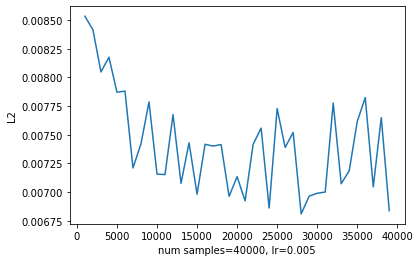

[0.008532394791021943, 0.008414504067972303, 0.008047324718907475, 0.008175565665587782, 0.00787050740979612, 0.00788035299256444, 0.007211404776200652, 0.0074215594436973335, 0.007785828331485391, 0.007158068826422095, 0.0071531022358685735, 0.007675722209736705, 0.007077051930129528, 0.007430385055020451, 0.006982642624527216, 0.007417090306058526, 0.0074016486806795, 0.007414912341162563, 0.006964006576687097, 0.0071348229162395, 0.0069243065249174835, 0.00741720231808722, 0.007557827528566122, 0.006861672485247255, 0.0077279403656721115, 0.0073898509051650765, 0.0075202611908316615, 0.006810703299939633, 0.0069658626969903705, 0.006990446802228689, 0.0070011173188686375, 0.007775503870099783, 0.007073644321411848, 0.007187565809115767, 0.007615352177992463, 0.007824595602229237, 0.007046517290174961, 0.0076499145086854695, 0.006838972967118025]


In [14]:
import matplotlib.pyplot as plt
loss_vals_x = np.arange(FLAGS.batch_size*100, train_sample_size, FLAGS.batch_size*100)
plt.plot(loss_vals_x, loss_vals)
plt.xlabel('num samples={}, lr={}'.format(train_sample_size, lr))
plt.ylabel('L2')
plt.show()
print(loss_vals)

In [15]:
# test: show imgs 
# Need work:
# saver.restore(sess, "./out/walk_train_aug/shiftx_l2_git0.005/output/model_20000.ckpt")

[-15 -12  -9  -6  -3   0   3   6   9  12  15]


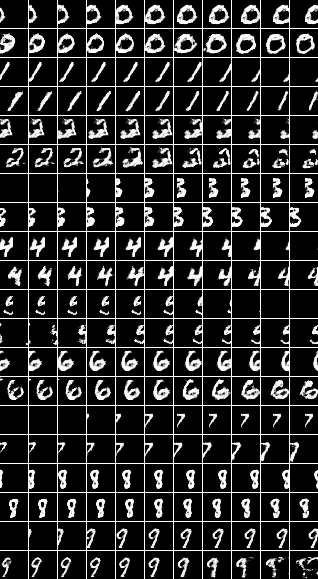

In [16]:
num_samples = 10
a = np.array([-15, -12, -9, -6, -3,  0,  3,  6,  9, 12, 15])

zs = np.random.uniform(-1, 1, size=(num_samples, FLAGS.z_dim))
y = np.arange(0,FLAGS.y_dim,1)
ys = np.zeros((num_samples, FLAGS.y_dim))
ys[np.arange(num_samples), y] = 1

im_targets = []
im_transformed = []
for i in range(a.shape[0]):
    feed_dict_out = {z_placeholder: zs, y_placeholder: ys}
    out_zs = sess.run(outputs_orig, feed_dict_out)
    target_fn, mask_out = get_target_np(out_zs, a[i])#, show_img=True, show_mask=True)
    im_targets.append(target_fn)
    ## get transformed:
    feed_dict = {z_placeholder: zs, y_placeholder: ys, alpha: a[i]/15, target: target_fn, mask: mask_out}
    samples = sess.run(transformed_output, feed_dict=feed_dict)
    im_transformed.append(samples)
#     imshow(imgrid(np.uint8(samples*255), cols=1))

ims = []
for j in range(FLAGS.y_dim):
    ims.append(np.stack([x[j, :, :, :] for x in im_targets], axis=0))
    ims.append(np.stack([x[j, :, :, :] for x in im_transformed], axis=0))

print(a)
imshow(imgrid(np.uint8(np.concatenate(ims)*255), cols=a.shape[0]))

In [17]:
loss_l2_sample = tf.reduce_sum(tf.multiply(tf.square(transformed_output-target), mask), axis=(1,2,3)) \
        / tf.reduce_sum(mask, axis=(1,2,3))

loss_l2_trained = loss

In [18]:
import logging
import sys
# import argparse
# from utils import *
# import graphs
# import constants
import time
import pdb
import os
# import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 14})
rc('text', usetex=True)

num_samples = 10000
vocab_size = FLAGS.y_dim
batch_size = FLAGS.batch_size

z_sample = np.random.uniform(-1, 1, size=(num_samples, FLAGS.z_dim))
y = np.arange(0,FLAGS.y_dim,1)
y_one_hot = np.zeros((len(y), FLAGS.y_dim))
y_one_hot[np.arange(len(y)), y] = 1
y_one_hot = np.tile(y_one_hot,[num_samples,1])

zs = z_sample
ys = y_one_hot
alphas = a 
alphas_no_log = a

# get alphas list
# if type(g) == graphs.ZoomTransform:
#     alp = np.linspace(1, opt.max_alpha, opt.num_alphas//2 + 1)
#     b = 1/alp
#     alphas = np.concatenate((np.delete(b[::-1], -1), alp), axis=0)
#     alphas = alphas[::-1]
# else:
#     alphas = np.linspace(-opt.max_alpha, opt.max_alpha, opt.num_alphas)
ylabel = 'L2 Distance'
dist_tensor = loss_l2_sample
dist_trained_tensor = loss_l2_trained
# dist_trained_tensor = loss_l2_sample
# dist_info = compute_transform_similarity(...)
# plot_similarity(dist_info...)

# # if opt.distance == 'l2':
# #     ylabel = 'L2 Distance'
# #     dist_tensor = g.loss_l2_sample
# # elif opt.distance == 'lpips':
# #     ylabel = 'Perceptual Distance'
# #     dist_tensor = g.loss_lpips_sample
# dist_info = compute_transform_similarity(ys, zs, alphas, dist_tensor)
# plot_similarity(alphas, dist_info, ylabel, output_dir, 'category_all')
# # if opt.category:
# #     for c in opt.category:
# #         ys = [c] * num_samples
# #         ys = one_hot_if_needed(ys, vocab_size)
# #         dist_info = compute_transform_similarity(g, ys, zs, alphas,
# #                                                  dist_tensor)
# #         plot_similarity(alphas, dist_info, ylabel,
# #                         output_dir, 'category_{}'.format(c))
# # else:
# #     categories = np.random.randint(0, vocab_size, size=num_samples)
# #     ys = one_hot_if_needed(categories, vocab_size)
# #     dist_info = compute_transform_similarity(g, ys, zs, alphas,
# #                                              dist_tensor)
# #     plot_similarity(alphas, dist_info, ylabel, output_dir,
# #                     'category_all')

In [19]:
def scale_test_alpha_for_graph(alpha, zs_batch):
#     alpha = np.log(alpha) # only for zoom
    batch_size = zs_batch.shape[0]
    slider = alpha * np.ones((batch_size, Nsliders))
    return slider

In [20]:
alphas = alphas_no_log
dist_info = np.empty((num_samples, len(alphas) - 1))
dist_trained_info = np.empty((num_samples, len(alphas)))

for batch_start in range(0, num_samples, batch_size):
    s = slice(batch_start, min(num_samples, batch_start + batch_size))
    ys_batch = ys[s]
    zs_batch = zs[s]
    im_buffer = None # save the first set of images, for consecutive diff
    for i, a in enumerate(alphas):
        slider = scale_test_alpha_for_graph(a, zs_batch)
        input_test = {y_placeholder: ys_batch,
                      z_placeholder: zs_batch,
                      alpha: slider}
        im_transform = sess.run(transformed_output, feed_dict=input_test)
#         imshow(imgrid(np.uint8(im_transform*255), cols=1))
        if im_buffer is not None:
            feed_dict = {
                mask: np.ones_like(im_transform),
                transformed_output: im_transform,
                target: im_buffer
            }
            # compute consecutive lpips diffs
            dist_info[s, i-1] = sess.run(dist_tensor, feed_dict=feed_dict)
#             print('consecutive diffs:', sess.run(dist_tensor, feed_dict=feed_dict))
        im_buffer = im_transform
    
        ## now compute the loss of train:
        ## already have im_transform, so get target and mask from G(a=0,z)
        out_zs = sess.run(outputs_orig, input_test)
        target_out, mask_out = get_target_np(out_zs, a)
#         imshow(imgrid(np.uint8(im_transform*255), cols=1))
#         imshow(imgrid(np.uint8(target_out*255), cols=1))
#         imshow(imgrid(np.uint8(mask_out*255), cols=1))
        feed_dict = {
            mask: mask_out,
            transformed_output: im_transform,
            target: target_out
        }
        dist_trained_info[s, i] = sess.run(dist_trained_tensor, feed_dict=feed_dict)

alpha: -13.50, dist 0.00 +/- 0.00
alpha: -10.50, dist 0.00 +/- 0.00
alpha: -7.50, dist 0.01 +/- 0.00
alpha: -4.50, dist 0.03 +/- 0.02
alpha: -1.50, dist 0.12 +/- 0.04
alpha: 1.50, dist 0.13 +/- 0.05
alpha: 4.50, dist 0.03 +/- 0.02
alpha: 7.50, dist 0.01 +/- 0.00
alpha: 10.50, dist 0.00 +/- 0.00
alpha: 13.50, dist 0.00 +/- 0.00
2019-09-21 15:55:32,238 [MainThread  ] [INFO ]  No LaTeX-compatible font found for the serif font family in rcParams. Using default.
2019-09-21 15:55:32,240 [MainThread  ] [INFO ]  No LaTeX-compatible font found for the serif font family in rcParams. Using default.


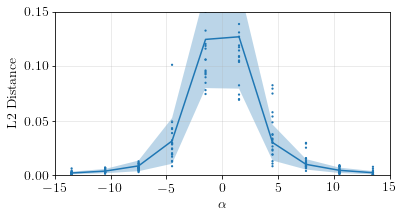

In [21]:
## plots and saves the computed similarity matrix
import os
output_dir = './out/plots/'
savefile = 'shiftx_aug_argminW_transform_effect_plots'

alphas = alphas_no_log

xlabel = r'$\alpha$'
if np.min(alphas) > 0:
    alphas = np.log(alphas)
    xlabel = r'$\log(\alpha)$'
    
f, ax = plt.subplots(figsize=(6, 3))
xaxis = np.mean([alphas[:-1], alphas[1:]], axis=0)
mu = np.mean(dist_info, axis=0)
sd = np.std(dist_info, axis=0)
p = ax.plot(xaxis, mu)
ax.fill_between(xaxis, mu-sd, mu+sd, alpha=0.3)
xscatter = np.tile(xaxis, (20, 1))
yscatter = dist_info[:20] # take the first 20 samples
ax.scatter(xscatter, yscatter, marker='.',
           edgecolors='none', s=20, color=p[0].get_color())
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

# ax.set_ylim([0, 0.8])
ax.set_ylim([0, 0.15])
ax.grid(alpha=0.3)
# ax.set_xlim([np.min(alphas), np.max(alphas)])
ax.set_xlim([np.min(alphas), np.max(alphas)])

for (x, m, s) in zip(xaxis, mu, sd):
    print("alpha: {:.2f}, dist {:.2f} +/- {:.2f}".format(x, m, s))

f.savefig(os.path.join(output_dir, savefile + '.png'),
          bbox_inches="tight", pad_inches=0)
f.savefig(os.path.join(output_dir, savefile + '.pdf'),
          bbox_inches="tight", pad_inches=0)

In [22]:
dist_trained_joint = np.load("dist_trained_info_shiftx_aug_argminGW.npy")

alpha: -15.00, dist 0.13 +/- 0.02
alpha: -12.00, dist 0.13 +/- 0.02
alpha: -9.00, dist 0.13 +/- 0.02
alpha: -6.00, dist 0.13 +/- 0.02
alpha: -3.00, dist 0.12 +/- 0.02
alpha: 0.00, dist 0.00 +/- 0.00
alpha: 3.00, dist 0.13 +/- 0.02
alpha: 6.00, dist 0.13 +/- 0.02
alpha: 9.00, dist 0.14 +/- 0.02
alpha: 12.00, dist 0.14 +/- 0.02
alpha: 15.00, dist 0.15 +/- 0.02


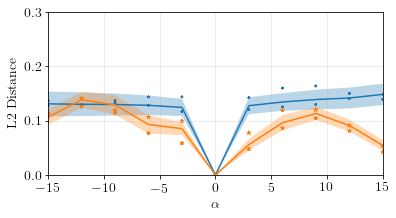

In [23]:
## plots and saves the computed similarity matrix
import os
output_dir = './out/plots/'
savefile = 'shiftx_aug_argminW_loss_trained_plots'

alphas = alphas_no_log

xlabel = r'$\alpha$'
if np.min(alphas) > 0:
    alphas = np.log(alphas)
    xlabel = r'$\log(\alpha)$'
    
f, ax = plt.subplots(figsize=(6, 3))
# xaxis = np.mean([alphas[:-1], alphas[1:]], axis=0)
xaxis = np.mean([alphas[:], alphas[:]], axis=0)

### For shift no joint
mu = np.mean(dist_trained_info, axis=0)
sd = np.std(dist_trained_info, axis=0)
p = ax.plot(xaxis, mu)
ax.fill_between(xaxis, mu-sd, mu+sd, alpha=0.3)
xscatter = np.tile(xaxis, (20, 1))
yscatter = dist_trained_info[:20] # take the first 20 samples

### For shift join
mu_j = np.mean(dist_trained_joint, axis=0)
sd_j = np.std(dist_trained_joint, axis=0)
p_j = ax.plot(xaxis, mu_j)
ax.fill_between(xaxis, mu_j-sd_j, mu_j+sd_j, alpha=0.3)
xscatter_j = np.tile(xaxis, (20,1))
yscatter_j = dist_trained_joint[:20]

ax.scatter(xscatter, yscatter, marker='.',
           edgecolors='none', s=20, color=p[0].get_color())

ax.scatter(xscatter_j, yscatter_j, marker='*', edgecolors='none', s=20, color=p_j[0].get_color())

ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

# ax.set_ylim([0, 0.8])
ax.set_ylim([0, 0.3])
ax.grid(alpha=0.3)
# ax.set_xlim([np.min(alphas), np.max(alphas)])
ax.set_xlim([np.min(alphas), np.max(alphas)])

for (x, m, s) in zip(xaxis, mu, sd):
    print("alpha: {:.2f}, dist {:.2f} +/- {:.2f}".format(x, m, s))

f.savefig(os.path.join(output_dir, savefile + '.png'),
          bbox_inches="tight", pad_inches=0)
f.savefig(os.path.join(output_dir, savefile + '.pdf'),
          bbox_inches="tight", pad_inches=0)